### Importing Libraries

In [143]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
import string
import demoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [144]:
# Downloading NLTK Resources

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASHAD\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASHAD\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASHAD\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ASHAD\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\ASHAD\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

### EDA

In [145]:
#Loading the data

df = pd.read_csv("twitter_training.csv")

In [146]:
df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [147]:
#Renaming the columns

df.rename(columns={'Positive': 'Response'}, inplace=True)
df.rename(columns={'im getting on borderlands and i will murder you all ,': 'Tweet'}, inplace=True)
df.rename(columns={'Borderlands':'Games'},inplace =True)
df.rename(columns={'2401':'Index'},inplace=True)

In [148]:
df.head()

,Index,Games,Response,Tweet
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [149]:
df.shape

(74681, 4)

In [150]:
df.drop_duplicates(inplace=True)

In [151]:
df.shape

(71981, 4)

In [152]:
df.dropna(inplace=True)

In [153]:
df.shape

(71655, 4)

In [154]:
df.isnull().sum()

Index       0
Games       0
Response    0
Tweet       0
dtype: int64

C:\Users\ASHAD\AppData\Local\Temp\ipykernel_13036\3392375544.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y="Games",data=df,palette="turbo")


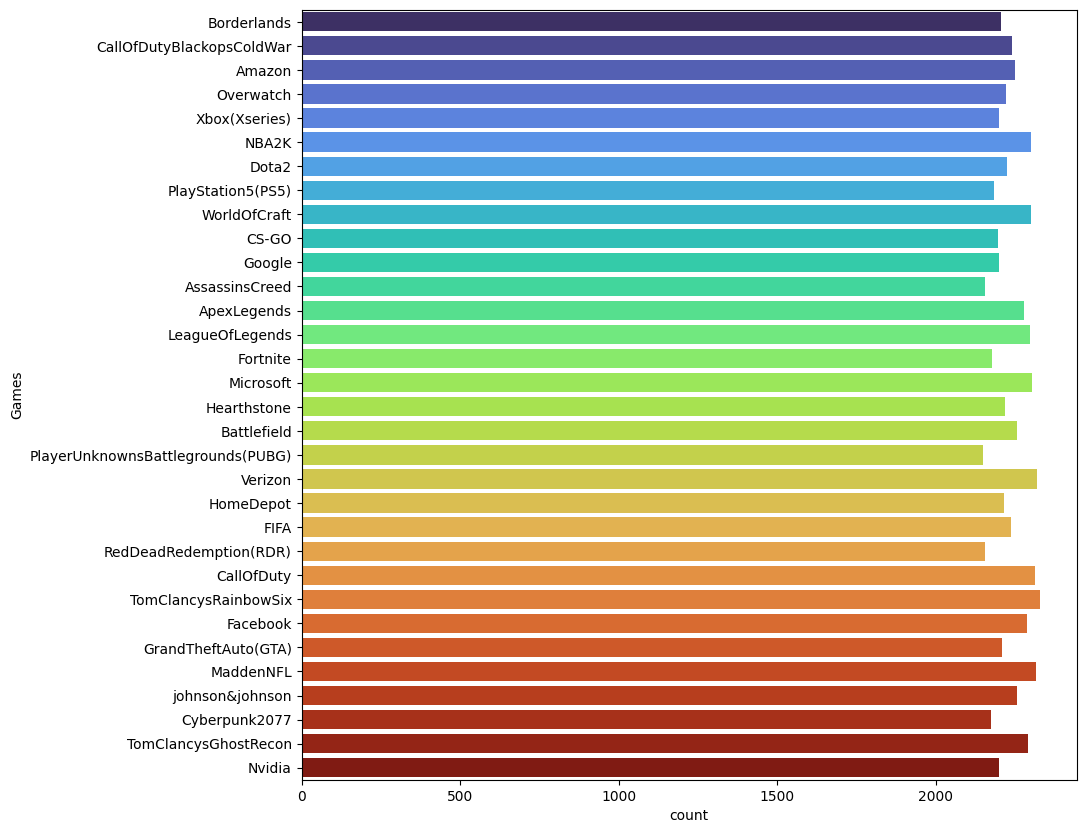

In [155]:
# Visualizing Game Distribution

plt.figure(figsize=(10,10))
sns.countplot(y="Games",data=df,palette="turbo")
plt.show()

### Preprocess Function

In [162]:
# Text Preprocessing Functions

stop_words = set(stopwords.words('english'))

def remove_punt(text):
    punctuations_free = "".join([char for char in text if char not in string.punctuation])
    return punctuations_free

def tokenization(text):
    tokens = re.split(' ', text)  # Split on non-alphanumeric characters
    return tokens

def remove_stop_words(text):
    output = [i for i in text if i.lower() not in stop_words]  # Case-insensitive check
    return output

def remove_numbers(text_list):
    text = ' '.join(text_list)
    text = re.sub(r'\d+', '', text)
    return text.split()

def remove_emoji(text_list):
    text = ' '.join(text_list)
    dem = demoji.findall(text)
    for item in dem.keys():
        text = text.replace(item, '')
    return text.split()

def remove_url(text_list):
    text = ' '.join(text_list)
    url = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    return url.split()

In [163]:
## Text Preprocessing with Lemmatization and POS Tagging


def preprocess(text):
    if not isinstance(text, str):
        raise ValueError("Input should be a string.")
 
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    
    def get_wordnet_pos(tag):
        if tag.startswith('V'):
            return 'v'  # verb
        elif tag.startswith('N'):
            return 'n'  # noun
        elif tag.startswith('R'):
            return 'r'  # adverb
        else:
            return 'a'  

    filtered_tokens = [
        lemmatizer.lemmatize(token.lower(), get_wordnet_pos(tag))  
        for token, tag in pos_tags
        if token.lower() not in stop_words and token not in string.punctuation
    ]
    return " ".join(filtered_tokens)


### Apply preprocess function on dataframe

In [164]:
# Text Cleaning and Preprocessing Pipeline

df['text_lower']=df['Tweet'].apply(lambda x:x.lower())
df['cleaned_text']=df['text_lower'].apply(lambda x:remove_punt(x))
df['numbers_removed']= df['cleaned_text'].apply(lambda x:(remove_numbers(x)))
df['url_removed']= df['numbers_removed'].apply(lambda x:(remove_url(x))) 
df['emoji_removed']= df['url_removed'].apply(lambda x:(remove_emoji(x)))
df['emoji_removed'] = df['emoji_removed'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
df['tokenized_text']=df['emoji_removed'].apply(lambda x:tokenization(x))
df['no_stop_text']=df['tokenized_text'].apply(lambda x:remove_stop_words(x))

In [165]:
df['textPreprocessed']=df['Tweet'].apply( preprocess)

In [166]:
df

,Index,Games,Response,Tweet,text_lower,cleaned_text,numbers_removed,url_removed,emoji_removed,tokenized_text,no_stop_text,textPreprocessed
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,i am coming to the borders and i will kill you...,i am coming to the borders and i will kill you...,"[i, a, m, c, o, m, i, n, g, t, o, t, h, e, b, ...","[i, a, m, c, o, m, i, n, g, t, o, t, h, e, b, ...",i a m c o m i n g t o t h e b o r d e r s a n ...,"[i, a, m, c, o, m, i, n, g, t, o, t, h, e, b, ...","[c, n, g, h, e, b, r, e, r, n, w, l, l, k, l, ...",come border kill
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting on borderlands and i will kill you ...,im getting on borderlands and i will kill you all,"[i, m, g, e, t, t, i, n, g, o, n, b, o, r, d, ...","[i, m, g, e, t, t, i, n, g, o, n, b, o, r, d, ...",i m g e t t i n g o n b o r d e r l a n d s a ...,"[i, m, g, e, t, t, i, n, g, o, n, b, o, r, d, ...","[g, e, n, g, n, b, r, e, r, l, n, n, w, l, l, ...",im get borderland kill
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming on borderlands and i will murder you...,im coming on borderlands and i will murder you...,"[i, m, c, o, m, i, n, g, o, n, b, o, r, d, e, ...","[i, m, c, o, m, i, n, g, o, n, b, o, r, d, e, ...",i m c o m i n g o n b o r d e r l a n d s a n ...,"[i, m, c, o, m, i, n, g, o, n, b, o, r, d, e, ...","[c, n, g, n, b, r, e, r, l, n, n, w, l, l, u, ...",im come borderland murder
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting on borderlands 2 and i will murder ...,im getting on borderlands 2 and i will murder ...,"[i, m, g, e, t, t, i, n, g, o, n, b, o, r, d, ...","[i, m, g, e, t, t, i, n, g, o, n, b, o, r, d, ...",i m g e t t i n g o n b o r d e r l a n d s a ...,"[i, m, g, e, t, t, i, n, g, o, n, b, o, r, d, ...","[g, e, n, g, n, b, r, e, r, l, n, n, w, l, l, ...",im get borderland 2 murder
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,im getting into borderlands and i can murder y...,im getting into borderlands and i can murder y...,"[i, m, g, e, t, t, i, n, g, i, n, t, o, b, o, ...","[i, m, g, e, t, t, i, n, g, i, n, t, o, b, o, ...",i m g e t t i n g i n t o b o r d e r l a n d ...,"[i, m, g, e, t, t, i, n, g, i, n, t, o, b, o, ...","[g, e, n, g, n, b, r, e, r, l, n, n, c, n, u, ...",im get borderland murder
...,...,...,...,...,...,...,...,...,...,...,...,...
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...,just realized that the windows partition of my...,just realized that the windows partition of my...,"[j, u, s, t, r, e, a, l, i, z, e, d, t, h, a, ...","[j, u, s, t, r, e, a, l, i, z, e, d, t, h, a, ...",j u s t r e a l i z e d t h a t t h e w i n d ...,"[j, u, s, t, r, e, a, l, i, z, e, d, t, h, a, ...","[j, u, r, e, l, z, e, h, h, e, w, n, w, p, r, ...",realize window partition mac like 6 year behin...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...,just realized that my mac window partition is ...,just realized that my mac window partition is ...,"[j, u, s, t, r, e, a, l, i, z, e, d, t, h, a, ...","[j, u, s, t, r, e, a, l, i, z, e, d, t, h, a, ...",j u s t r e a l i z e d t h a t m y m a c w i ...,"[j, u, s, t, r, e, a, l, i, z, e, d, t, h, a, ...","[j, u, r, e, l, z, e, h, c, w, n, w, p, r, n, ...",realize mac window partition 6 year behind nvi...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...,just realized the windows partition of my mac ...,just realized the windows partition of my mac ...,"[j, u, s, t, r, e, a, l, i, z, e, d, t, h, e, ...","[j, u, s, t, r, e, a, l, i, z, e, d, t, h, e, ...",j u s t r e a l i z e d t h e w i n d o w s p ...,"[j, u, s, t, r, e, a, l, i, z, e, d, t, h, e, ...","[j, u, r, e, l, z, e, h, e, w, n, w, p, r, n, ...",realize window partition mac 6 year behind nvi...
74679,9200,Nvidia,Positive,Just realized between the win

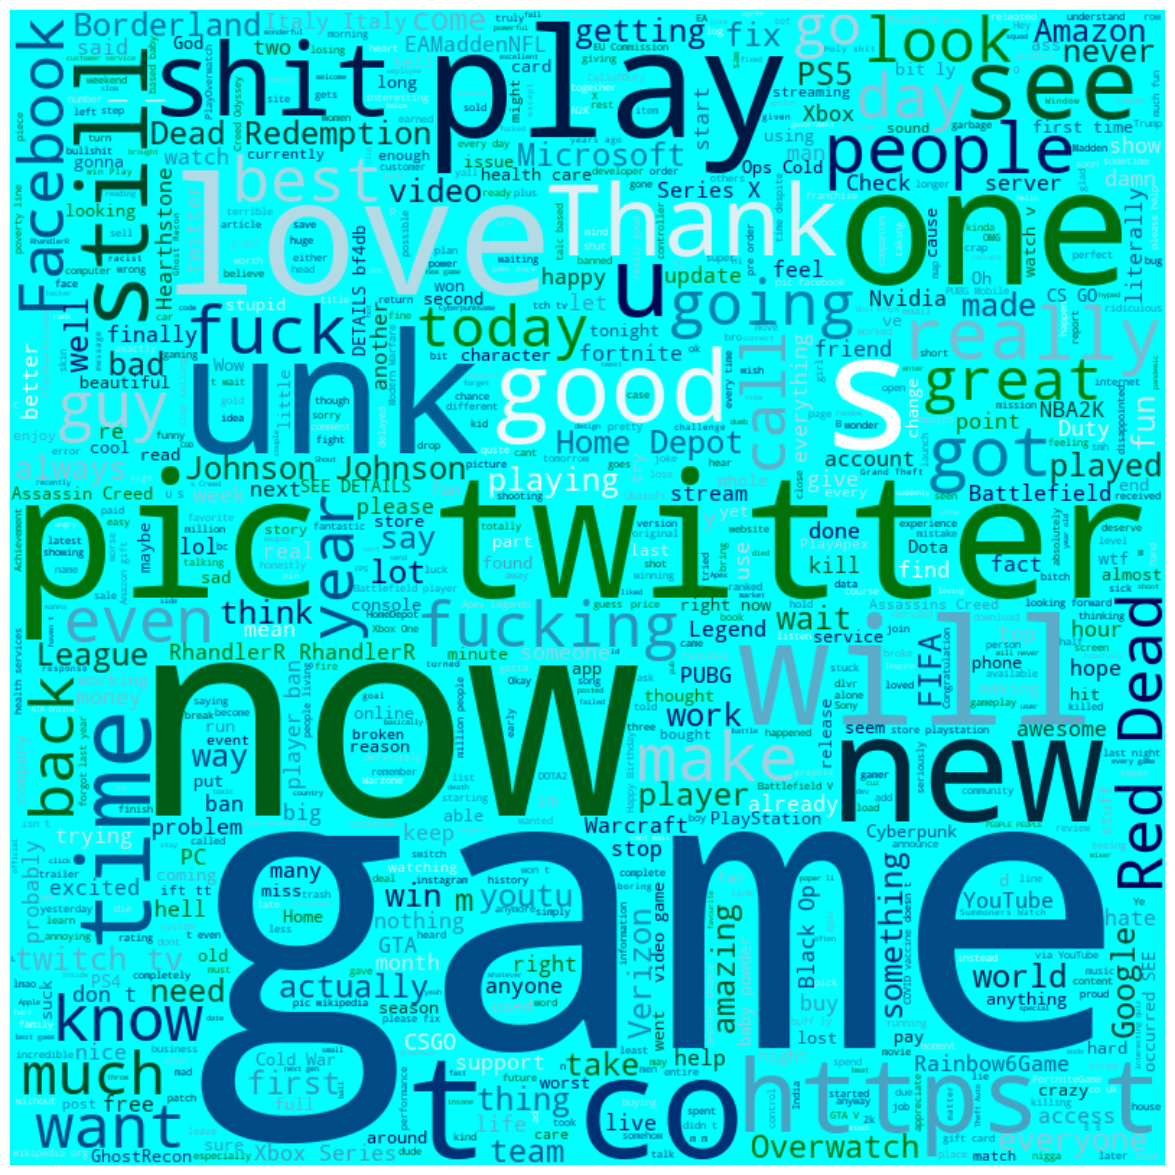

In [167]:
# Word Cloud Visualization for Tweet Data

plt.figure(figsize=(15,15))
all_text=" ".join(df['Tweet'].values.tolist())
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS, background_color='cyan', max_words=800,colormap="ocean").generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Encoding target column

In [120]:
encoder = LabelEncoder()
df["Response_num"] = encoder.fit_transform(df["Response"])

In [121]:
df.head()

,Index,Games,Response,Tweet,text_lower,cleaned_text,numbers_removed,url_removed,emoji_removed,tokenized_text,no_stop_text,textPreprocessed,Response_num
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,i am coming to the borders and i will kill you...,i am coming to the borders and i will kill you...,"[i, a, m, c, o, m, i, n, g, t, o, t, h, e, b, ...","[i, a, m, c, o, m, i, n, g, t, o, t, h, e, b, ...",i a m c o m i n g t o t h e b o r d e r s a n ...,"[i, a, m, c, o, m, i, n, g, t, o, t, h, e, b, ...","[c, n, g, h, e, b, r, e, r, n, w, l, l, k, l, ...",come border kill,3
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting on borderlands and i will kill you ...,im getting on borderlands and i will kill you all,"[i, m, g, e, t, t, i, n, g, o, n, b, o, r, d, ...","[i, m, g, e, t, t, i, n, g, o, n, b, o, r, d, ...",i m g e t t i n g o n b o r d e r l a n d s a ...,"[i, m, g, e, t, t, i, n, g, o, n, b, o, r, d, ...","[g, e, n, g, n, b, r, e, r, l, n, n, w, l, l, ...",im get borderland kill,3
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming on borderlands and i will murder you...,im coming on borderlands and i will murder you...,"[i, m, c, o, m, i, n, g, o, n, b, o, r, d, e, ...","[i, m, c, o, m, i, n, g, o, n, b, o, r, d, e, ...",i m c o m i n g o n b o r d e r l a n d s a n ...,"[i, m, c, o, m, i, n, g, o, n, b, o, r, d, e, ...","[c, n, g, n, b, r, e, r, l, n, n, w, l, l, u, ...",im come borderland murder,3
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting on borderlands 2 and i will murder ...,im getting on borderlands 2 and i will murder ...,"[i, m, g, e, t, t, i, n, g, o, n, b, o, r, d, ...","[i, m, g, e, t, t, i, n, g, o, n, b, o, r, d, ...",i m g e t t i n g o n b o r d e r l a n d s a ...,"[i, m, g, e, t, t, i, n, g, o, n, b, o, r, d, ...","[g, e, n, g, n, b, r, e, r, l, n, n, w, l, l, ...",im get borderland 2 murder,3
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,im getting into borderlands and i can murder y...,im getting into borderlands and i can murder y...,"[i, m, g, e, t, t, i, n, g, i, n, t, o, b, o, ...","[i, m, g, e, t, t, i, n, g, i, n, t, o, b, o, ...",i m g e t t i n g i n t o b o r d e r l a n d ...,"[i, m, g, e, t, t, i, n, g, i, n, t, o, b, o, ...","[g, e, n, g, n, b, r, e, r, l, n, n, c, n, u, ...",im get borderland murder,3


### Split data into train and test

In [122]:
X_train,X_test,y_train,y_test = train_test_split(df["textPreprocessed"],df["Response_num"],test_size=.2,random_state=123,stratify=df["Response_num"])

In [123]:
print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (57324,)
Shape of X_test:  (14331,)


# Machine Learning Model

### Random Forest 

In [174]:
#Creating Classifier

clr = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('random_forest', (RandomForestClassifier()))
])

In [175]:
#Model Training
clr.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('random_forest', RandomForestClassifier())])

In [176]:
# Get prediction
y_pred = clr.predict(X_test)

In [177]:
# Print accuracy score
print(accuracy_score(y_test,y_pred))

0.9108924708673505


In [178]:
#print Classification Report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.85      0.91      2507
           1       0.93      0.92      0.92      4340
           2       0.93      0.91      0.92      3542
           3       0.85      0.94      0.89      3942

    accuracy                           0.91     14331
   macro avg       0.92      0.91      0.91     14331
weighted avg       0.91      0.91      0.91     14331



# Model Testing

### Load the Text

In [179]:
test_df = pd.read_csv("twitter_validation.csv",names = ["Index", "Company" , "Label", "Text"])

In [180]:
test_df.head()

,Index,Company,Label,Text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [181]:
test_text = test_df["Text"][33]
print(f"{test_text} ==> {test_df['Label'][33]}")

The things I would do for a @nvidia 3090... unspeakable! 🧐 ==> Positive


### Apply Preprocess

In [182]:
test_text_preprocessed = [preprocess(test_text)]
test_text_preprocessed

['thing would nvidia 3090 ... unspeakable 🧐']

In [183]:
#Get Prediction
test_text = clr.predict(test_text_preprocessed)

# Output

In [184]:
classes = ['Irrelevant', 'Natural', 'Negative', 'Positive']

print(f"True Label: {test_df['Label'][33]}")
print(f'Predict Label: {classes[test_text[0]]}')

True Label: Positive
Predict Label: Positive
